In [18]:
import gc
import re
import string
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
def cat_cleaner(df,col):
    """
    Takes in the df and the column containing messy, sub cats.

    eg:
    pd.get_dummies:
       col                 A | A,B | B | B,A
    0|  A              0|  1    0    0    0
    1| A,B  -onehot->  1|  0    1    0    0
    2|  B              2|  0    0    1    0
    3| B,A             3|  0    0    0    1

    this:

       col                       A | B
    0|  A                    0|  1   0
    1| A,B  -cat_cleaner ->  1|  1   1
    2|  B                    2|  0   1
    3| B,A                   3|  1   1



    """
    def cat(text):
        text =[word for word in text.split(',')]
        text =[word.strip() for word in text]
        return(text)


    df[col] = df[col].astype('str')
    clean_cats = df[col].apply(lambda x:cat(x))
    p = pd.get_dummies(clean_cats.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
    return p


def text_cleaner(text,all_stop):
    """
    removes words contained in all_stop (list containing more words to remove)
    clean_str = text_cleaner(dirty_string)
    """
    regex = re.compile('[%s]' % re.escape(string.punctuation))

    text = text.lower()
    text = text.replace('<!--DONOTREMOVEESSAYDIVIDER-->',' ')
    text = text.replace('\n' , ' ')
    text = regex.sub('',text)
    text = ' '.join([word for word in text.split() if word not in all_stop])
    return(text)

def compress(df,encode=[],num=[],byte_str = False):
    """
    Experimental:
    It should compress the space of the df
    """
    pre_ = df[num+encode].memory_usage(deep=True)

    for i in num:
        if df[i].astype(np.float16).memory_usage(deep=True)<df[i].memory_usage(deep=True):
            df[i] = df[i].astype(np.float16)
        else:
            pass

    if byte_str:
        for j in encode:
            if df[j].astype(np.string_).memory_usage(deep=True)<df[j].memory_usage(deep=True):
                df[j] = df[j].astype(np.string_)
            else:
                pass
    else:
        for j in encode:
            if df[j].astype(str).memory_usage(deep=True)<df[j].memory_usage(deep=True):
                df[j] = df[j].astype(str)
            else:
                pass
            
    post_ = df[num+encode].memory_usage(deep=True)
    print("Data Usage - change:{}".format((post_-pre_)))
    print("Total Change: {}".format((post_-pre_).sum()))
    return

In [6]:
bad_form = {'Projects'  : pd.read_csv('./Input/New/Projects.csv'),
            'Resources' : pd.read_csv('./Input/New/Resources.csv'),
            'Schools'   : pd.read_csv('./Input/New/Schools.csv'),
            'Teachers'  : pd.read_csv('./Input/New/Teachers.csv')}

In [19]:
def plot_empties(bad_form):
    """
    Makes a pretty heatmap of empty columns
    """
    plt.figure(figsize=(15,15))

    i = 1
    for j in bad_form:
        plt.subplot(230+i)
        sns.heatmap(pd.DataFrame(bad_form[j].isnull().sum()/bad_form[j].shape[0]*100),
                    annot=True,cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
        plt.title(j)
        i+=1

    plt.subplots_adjust(wspace = 1.6)
    return

### Null Analysis

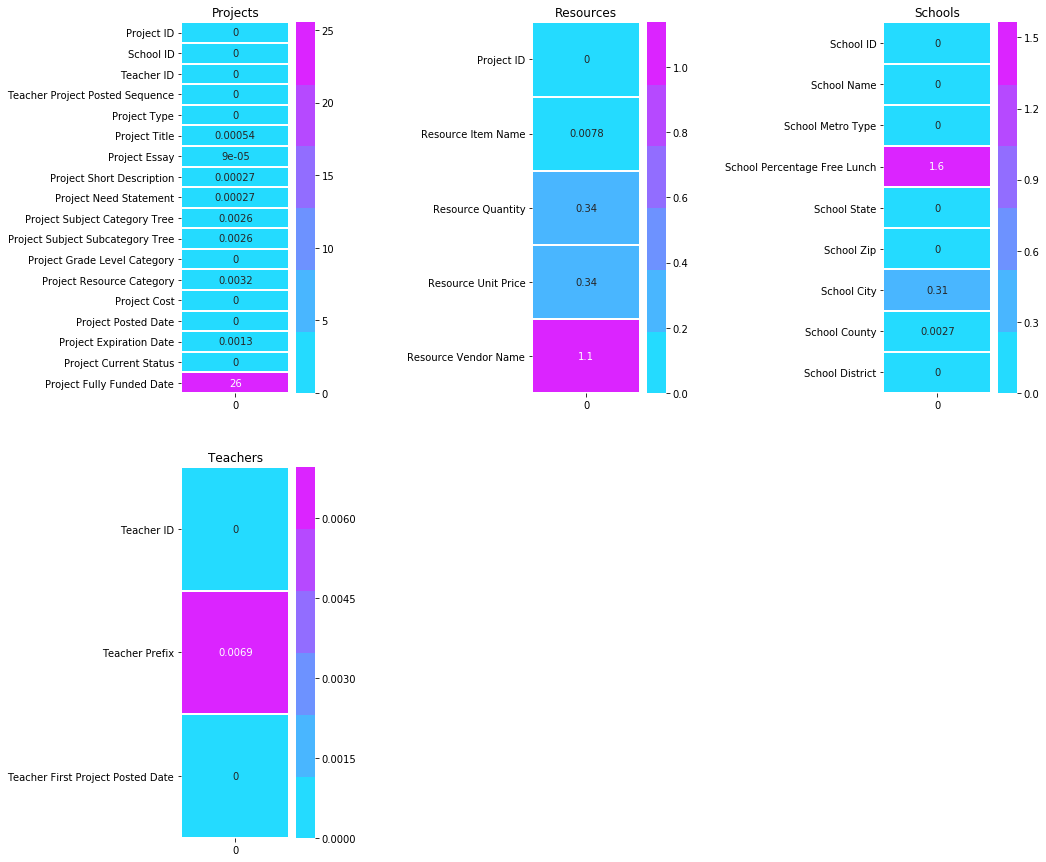

In [22]:
plot_empties(bad_form)

### Project Null Analysis
| Column | Number of Nulls | Treatment |
| ----- | ----- | ----|
| Project ID | 0 | N/a |
| School ID | 0 | N/a |
| Teacher ID | 0 | N/a |
| Teacher Project Posted Sequence | 0 | Column will be dropped* |
| Project Type | 0 | N/a |
| Project Title | 6 | Column will be dropped* |
| Project Essay | 1 | Unfortunately drop rows |
| Project Short Description | 3 | Column will be dropped* |
| Project Need Statement | 3 | Unfortunately drop rows |
| Project Subject Category Tree | 29 | This may be inputed through the Cat_Cleaner |
| Project Subject Subcategory Tree | 29 | Column will be dropped*|
| Project Grade Level Category | 0 | N/a |
| Project Resource Category | 36 | Unfortuntaely drop rows |
| Project Cost | 0 | N/a |
| Project Posted Date | 0 | N/a |
| Project Expiration Date | 14 | Column will be dropped* |
| Project Current Status | 0 | N/a |
| Project Fully Funded Date | 283253 | Column will be dropped* |

Columns to be dropped from 'Projects'
 - Teacher Project Posted Sequence : high multicolinearity with 'Teacher Previous Posting'

 - Project Title : Essays will be primary NLP sources + during preliminary model generation  'Project Title's tf-idf features had minimal influcence
 
 - Project Short Description : Content should be the same/lessor than in 'Project Essay'
 
 - Project Subject Subcategory Tree : SO MANY unique values, I'd rather just have a good 'Category' Metric
 
 - Project Expiration Date & Project Fully Funded Date : I want the model to be a binary classifier of "Fully Funded" & "Not Fully Funded", as such I will remove all the projects which currently 'Live', and treat

In [27]:
bad_form['Projects']['Project Current Status'].unique()

array(['Fully Funded', 'Expired', 'Live'], dtype=object)

In [28]:
### Target Variable Assignment
df = bad_form['Projects']
df = df[df['Project Current Status'] != 'Live']
df['Project Current Status'] = df['Project Current Status'].apply(lambda x: 1 if x == 'Fully Funded' else 0)

#Adding dt features
df['Project Posted Date'] = pd.to_datetime(df['Project Posted Date'])
df['Project Posted Year'] = df['Project Posted Date'].dt.year.astype(str)
df['Project Posted Month'] = df['Project Posted Date'].dt.month
df['Project Posted Month'] = df['Project Posted Month'].apply(lambda x: calendar.month_abbr[x])

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
#Adding dt features
df['Project Posted Date'] = pd.to_datetime(df['Project Posted Date'])
df['Project Posted Year'] = df['Project Posted Date'].dt.year.astype(str)
df['Project Posted Month'] = df['Project Posted Date'].dt.month
df['Project Posted Month'] = df['Project Posted Month'].apply(lambda x: calendar.month_abbr[x])

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

### Dropping Features

In [30]:
for i in ['Teacher Project Posted Sequence', 'Project Fully Funded Date', 
          'Project Expiration Date', 'Project Subject Subcategory Tree', 
          'Project Posted Date','Project Title','Project Short Description']:
    del df[i]
encode_cols = ['Project Type','Project Posted Year','Project Posted Month',
               'Project Grade Level Category','Project Resource Category',]
num_cols    = ['Project Cost']

### Treatment of Teachers

In [31]:
bad_form['Teachers'].isnull().sum()

Teacher ID                            0
Teacher Prefix                       28
Teacher First Project Posted Date     0
dtype: int64

### Teachers
| Column | Number of Nulls | Treatment |
| ----- | ----- | ----|
| Teacher ID | 0 | N/a |
| Teacher Prefix | 28 | Nulls (along with Mx.) will be set to 'Teacher', as to try to balance classes |
| Teacher First Posted Date | 0 | Column will be dropped |

In [35]:
bad_form['Teachers']['Teacher Prefix'].value_counts()

Mrs.       202142
Ms.        145761
Mr.         47480
Teacher      7404
Dr.            57
Mx.            28
Name: Teacher Prefix, dtype: int64

In [ ]:
#Treating Nulls in 'Teachers'
bad_form['Teachers']['Teacher Prefix'] = bad_form['Teachers']['Teacher Prefix'].apply(
    lambda x: 'Teacher' if x in ['Mx.', np.nan] else x)

df = df.merge(bad_form['Teachers'],on='Teacher ID').copy(deep=True)

#cols
encode_cols += ['Teacher Prefix']
num_cols    += []

#del
for i in ['Teacher ID','Teacher First Project Posted Date']:
    del df[i]
gc.collect()

In [32]:
### School Data

In [ ]:
bad_form['Schools'].isnull().sum()

In [ ]:
#very few, dropping nulls
bad_form['Schools'] = bad_form['Schools'].dropna()

#merging school to df
df = df.merge(bad_form['Schools'],on='School ID')
df['School Zip'] = df['School Zip'].astype(str)

#cols
encode_cols += ['School Metro Type','School State','School District','School Zip']
num_cols    += ['School Percentage Free Lunch']

#del
for i in ['School Name','School ID','School City','School County']:
    del df[i]
gc.collect()

### Funding/Resources Data

In [ ]:
#more funding features
bad_form['Resources']['Resource Total Cost'] = bad_form['Resources']['Resource Quantity'] * bad_form['Resources']['Resource Unit Price']
funding_agg = bad_form['Resources'].groupby('Project ID').agg(
    {'Resource Item Name': ['nunique'], 
     'Resource Quantity': ['sum'], 
     'Resource Total Cost': ['mean', 'sum','median','max','min']})

funding_agg.columns = ['Project num Unique Resources',
                   'Total Resource Quantity', 
                   'Mean Resource Cost', 
                   'Total Project Cost',
                   'Median Resource Cost',
                   'Most exp Resource Cost',
                   'Least exp Resource Cost']

#cols
encode_cols += []
num_cols    += list(funding_agg.columns.values)

#merging funding to df
funding_agg.reset_index(inplace=True)
df = df.merge(funding_agg,on='Project ID')

del funding_agg
gc.collect()

del df['Project ID']

In [ ]:
#Encoding
le_dict = {}
if One_Hot:
    df = df.merge(pd.get_dummies(df[encode_cols])
             ,left_index=True,right_index=True)
    for i in encode_cols:
        del df[i]
else:
    for c in encode_cols:
        encod = LabelEncoder()
        encod.fit(df[c].astype(str))
        df[c] = encod.transform(df[c].astype(str))
        le_dict[c] = dict(zip(encod.classes_, encod.transform(encod.classes_)))
    del encod

p = cat_cleaner(df,'Project Subject Category Tree')
df = df.merge(p,left_index=True,right_index=True)
del df['Project Subject Category Tree'], p

#Scaling
print('Scaling')
if Standard_Scale:
    Scalar = StandardScaler()
else:
    Scalar = MinMaxScaler()

df[num_cols] = Scalar.fit_transform(df[num_cols])

del LabelEncoder, Standard_Scale, Scalar
gc.collect()

In [ ]:
### Text Editing

print('Text Processing')

text_cols = ['Project Essay','Project Need Statement']

#adding more words to 'stopwords'
extra_words = ['student','students','education']
single_l = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in single_l:
    extra_words.append(j)
extra_words += stopwords.words("english")

for i in text_cols:
    print("{} Processing".format(str(i)))
    df[i] = df[i].apply(lambda x: text_cleaner(x,extra_words))

del text_cleaner, extra_words, single_l, stopwords

#Tfidf
tfidf = TfidfVectorizer(max_features=Tf_Features, ngram_range = (1,N_Gram))

for i in text_cols:
    print("{} TFIDF".format(str(i)))
    tfidf.fit(df[i])
    tf_cols = [str(i)+' contains: "'+str(x)+'"' for x in list(tfidf.vocabulary_.keys())]
    df = df.merge(pd.DataFrame(tfidf.transform(df[i]).todense(),columns=tf_cols), left_index=True, right_index=True)

for i in text_cols:
    del df[i]
del tfidf, tf_cols


X = df.drop(['Project Current Status'],axis=1)
y = df['Project Current Status']
df_cols = df.columns